In [1]:
!pip install mne -q

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
# Cell 0: Install libs (run once in Kaggle)
!pip install --quiet mne pyedflib scikit-learn seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.9 MB/s eta 0:00:00


# 1. ***IMPORTS***

In [4]:
import os, re, glob
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import gc

# **Load Data From edf Dir and check for missing**

In [5]:
DATA_ROOT = "/kaggle/input/physiobank-database-sleep-edfx-cassette/physiobank_database_sleep-edfx_sleep-cassette"

psg_files = sorted(glob.glob(os.path.join(DATA_ROOT, "*PSG.edf")))
hyp_files = sorted(glob.glob(os.path.join(DATA_ROOT, "*Hypnogram.edf")))

psg_dict = {re.findall(r'(SC\d+)', f)[0]: f for f in psg_files}
hyp_dict = {re.findall(r'(SC\d+)', f)[0]: f for f in hyp_files}

print("Total PSG:", len(psg_files))
print("Total Hypnogram:", len(hyp_files))


Total PSG: 152
Total Hypnogram: 153


In [6]:
# Trouver les patients présents dans les deux ensembles
common_ids = sorted(set(psg_dict.keys()) & set(hyp_dict.keys()))

# Trouver ceux qui manquent
missing_psg = sorted(set(hyp_dict) - set(psg_dict))
missing_hyp = sorted(set(psg_dict) - set(hyp_dict))

print(f"Paired subjects (by patient id): {len(common_ids)}")
print(f"Patients with Hypnogram but no PSG: {missing_psg}")
print(f"Patients with PSG but no Hypnogram: {missing_hyp}")


Paired subjects (by patient id): 152
Patients with Hypnogram but no PSG: ['SC4481']
Patients with PSG but no Hypnogram: []


# 2. Extract metadata from the Hypnogram File Function 

In [7]:
def extract_metadata(hyp_path):
    with open(hyp_path, 'rb') as f:
        header = f.read(256).decode('latin-1', errors='ignore')
    # Age and sex extraction
    match = re.search(r'(?:Male|Female)[_ ]?(\d+)', header)
    sex = "F" if "Female" in header else "M" if "Male" in header else None
    age = int(match.group(1)) if match else None
    return sex, age

# 3. Extract Sleep Stages from Hypnogram File Function 

In [8]:
def extract_sleep_stages(hyp_path):
    """
    Return a DataFrame with columns: time_sec, stage
    from hypnogram EDF annotations.
    """
    annotations = mne.read_annotations(hyp_path)
    df = pd.DataFrame({
        "time_sec": annotations.onset,  # start time in seconds
        "duration": annotations.duration,
        "stage": annotations.description
    })
    
    # Expand each stage to have one row per second
    df_expanded = pd.DataFrame({
        "time_sec": np.concatenate([np.arange(row.time_sec, row.time_sec + row.duration) 
                                    for _, row in df.iterrows()]),
        "stage": np.concatenate([[row.stage]*int(row.duration) for _, row in df.iterrows()])
    })
    return df_expanded

# 4. Visualising sleep stages and count it for the first patient 

In [9]:
df_ss = extract_sleep_stages("/kaggle/input/physiobank-database-sleep-edfx-cassette/physiobank_database_sleep-edfx_sleep-cassette/SC4001EC-Hypnogram.edf")
print(df_ss.head())
df_ss.groupby("stage").count()

   time_sec          stage
0       0.0  Sleep stage W
1       1.0  Sleep stage W
2       2.0  Sleep stage W
3       3.0  Sleep stage W
4       4.0  Sleep stage W


,time_sec
stage,
Sleep stage 1,1740
Sleep stage 2,7500
Sleep stage 3,3030
Sleep stage 4,3570
Sleep stage ?,6900
Sleep stage R,3750
Sleep stage W,59910


# 5. Create a DataFrame that contains all the patients with their HYP and PSG files also AGE and SEX  *Patient.csv*

In [10]:
# union of all patient ids found in either folder
all_ids = sorted(set(list(psg_dict.keys()) + list(hyp_dict.keys())))

rows = []
for pid in all_ids:
    psg_path = psg_dict.get(pid, "")
    hyp_path = hyp_dict.get(pid, "")
    has_both = bool(psg_path and hyp_path)
    rows.append({"patient_id": pid,
                 "hypnogram_path": hyp_path,
                 "psg_path": psg_path,
                 "has_both": has_both})

df = pd.DataFrame(rows).sort_values("patient_id").reset_index(drop=True)
df = df[df['has_both']==True]
# Save CSV (Kaggle working dir)
OUT_CSV = "/kaggle/working/patient_file_map.csv"
df.to_csv(OUT_CSV, index=False)

print(f"Saved CSV to: {OUT_CSV}")
print(df.head(10))
print()
print(f"Total patients found: {len(df)}")
print(f"Pairs (both files present): {df['has_both'].sum()}")
print(f"Missing PSG: {len(df[df['psg_path']==''])}, Missing Hypnogram: {len(df[df['hypnogram_path']==''])}")

Saved CSV to: /kaggle/working/patient_file_map.csv
  patient_id                                     hypnogram_path  \
0     SC4001  /kaggle/input/physiobank-database-sleep-edfx-c...   
1     SC4002  /kaggle/input/physiobank-database-sleep-edfx-c...   
2     SC4011  /kaggle/input/physiobank-database-sleep-edfx-c...   
3     SC4012  /kaggle/input/physiobank-database-sleep-edfx-c...   
4     SC4021  /kaggle/input/physiobank-database-sleep-edfx-c...   
5     SC4022  /kaggle/input/physiobank-database-sleep-edfx-c...   
6     SC4031  /kaggle/input/physiobank-database-sleep-edfx-c...   
7     SC4032  /kaggle/input/physiobank-database-sleep-edfx-c...   
8     SC4041  /kaggle/input/physiobank-database-sleep-edfx-c...   
9     SC4042  /kaggle/input/physiobank-database-sleep-edfx-c...   

                                            psg_path  has_both  
0  /kaggle/input/physiobank-database-sleep-edfx-c...      True  
1  /kaggle/input/physiobank-database-sleep-edfx-c...      True  
2  /kaggle/input

In [11]:
patients = df.copy()
patients.drop('has_both', axis=1, inplace=True) 
print(patients.head())

  patient_id                                     hypnogram_path  \
0     SC4001  /kaggle/input/physiobank-database-sleep-edfx-c...   
1     SC4002  /kaggle/input/physiobank-database-sleep-edfx-c...   
2     SC4011  /kaggle/input/physiobank-database-sleep-edfx-c...   
3     SC4012  /kaggle/input/physiobank-database-sleep-edfx-c...   
4     SC4021  /kaggle/input/physiobank-database-sleep-edfx-c...   

                                            psg_path  
0  /kaggle/input/physiobank-database-sleep-edfx-c...  
1  /kaggle/input/physiobank-database-sleep-edfx-c...  
2  /kaggle/input/physiobank-database-sleep-edfx-c...  
3  /kaggle/input/physiobank-database-sleep-edfx-c...  
4  /kaggle/input/physiobank-database-sleep-edfx-c...  


In [12]:
rows = []

# patients is your DataFrame with at least 'patient_id' and 'hypnogram_path' columns
print("patients columns:", patients.columns.tolist())

for idx, row in patients.iterrows():
    pid = str(row['patient_id'])
    hyp_path = row.get('hypnogram_path', '')  # or the actual column name you used

    if not isinstance(hyp_path, str) or hyp_path == "" or not os.path.exists(hyp_path):
        # file missing: record None or skip depending on your preference
        print(f"[WARN] Missing hypnogram for {pid}: '{hyp_path}'")
        sex, age = None, None
    else:
        try:
            sex, age = extract_metadata(hyp_path)   # your function
        except Exception as e:
            print(f"[ERROR] Failed to extract metadata for {pid} ({hyp_path}): {e}")
            sex, age = None, None

    rows.append({"patient_id": pid, "sex": sex, "age": age})

meta_df = pd.DataFrame(rows)
# Merge back into patients
patients['patient_id'] = patients['patient_id'].astype(str)
meta_df['patient_id'] = meta_df['patient_id'].astype(str)
merged = patients.merge(meta_df, on='patient_id', how='left', suffixes=('','_new'))

# Prefer new values when present (same logic as earlier)
for col in ('sex', 'age'):
    new_col = f"{col}_new"
    if new_col in merged.columns:
        if col in merged.columns:
            merged[col] = merged[new_col].combine_first(merged[col])
        else:
            merged[col] = merged[new_col]
        merged.drop(columns=[new_col], inplace=True)

OUT_CSV1 = "/kaggle/working/Patients.csv"
merged.to_csv(OUT_CSV1, index=False)
print(merged.head())

patients columns: ['patient_id', 'hypnogram_path', 'psg_path']
  patient_id                                     hypnogram_path  \
0     SC4001  /kaggle/input/physiobank-database-sleep-edfx-c...   
1     SC4002  /kaggle/input/physiobank-database-sleep-edfx-c...   
2     SC4011  /kaggle/input/physiobank-database-sleep-edfx-c...   
3     SC4012  /kaggle/input/physiobank-database-sleep-edfx-c...   
4     SC4021  /kaggle/input/physiobank-database-sleep-edfx-c...   

                                            psg_path sex  age  
0  /kaggle/input/physiobank-database-sleep-edfx-c...   F   33  
1  /kaggle/input/physiobank-database-sleep-edfx-c...   F   33  
2  /kaggle/input/physiobank-database-sleep-edfx-c...   F   33  
3  /kaggle/input/physiobank-database-sleep-edfx-c...   F   33  
4  /kaggle/input/physiobank-database-sleep-edfx-c...   F   26  


# 6. Reading the output CSV (Patients.csv)

In [13]:
patients = pd.read_csv("/kaggle/working/Patients.csv")
patients.head()

,patient_id,hypnogram_path,psg_path,sex,age
0,SC4001,/kaggle/input/physiobank-database-sleep-edfx-c...,/kaggle/input/physiobank-database-sleep-edfx-c...,F,33
1,SC4002,/kaggle/input/physiobank-database-sleep-edfx-c...,/kaggle/input/physiobank-database-sleep-edfx-c...,F,33
2,SC4011,/kaggle/input/physiobank-database-sleep-edfx-c...,/kaggle/input/physiobank-database-sleep-edfx-c...,F,33
3,SC4012,/kaggle/input/physiobank-database-sleep-edfx-c...,/kaggle/input/physiobank-database-sleep-edfx-c...,F,33
4,SC4021,/kaggle/input/physiobank-database-sleep-edfx-c...,/kaggle/input/physiobank-database-sleep-edfx-c...,F,26


# 7. Visualize the hypnogram of a patient function

In [14]:
def plot_hypnogram_from_raw(raw, ax=None, tmin=None, tmax=None, stage_map=None):
    """
    Plot a simple hypnogram from raw.annotations (onset, duration, description).
    raw: mne.io.Raw with annotations already attached (see set_annotations/read_annotations).
    tmin,tmax: time window in seconds (optional)
    stage_map: dict mapping annotation descriptions to integer codes (or strings).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,2))
    else:
        fig = ax.figure

    ann = raw.annotations
    if len(ann) == 0:
        ax.text(0.5, 0.5, "No annotations found", ha='center', va='center')
        return fig, ax

    # Default mapping (Sleep-EDF descriptions -> simplified vigilance)
    default_map = {
        "Sleep stage W": "awake",
        "Sleep stage 1": "drowsy",
        "Sleep stage 2": "drowsy",
        "Sleep stage 3": "asleep",
        "Sleep stage 4": "asleep",
        "Sleep stage R": "drowsy",
        "Sleep stage ?": "unknown"
    }
    if stage_map is None:
        stage_map = default_map

    # Build time grid (1-sec resolution by default)
    total_dur = raw.times[-1]
    if tmin is None: tmin = 0.
    if tmax is None: tmax = min(total_dur, tmin + 600.)  # default max 10min window
    t = np.arange(tmin, tmax, 1.0)  # 1-sec steps

    # initialize as unknown
    vals = np.array(["unknown"] * len(t), dtype=object)

    # fill with annotation labels
    for onset, dur, desc in zip(ann.onset, ann.duration, ann.description):
        seg_start = onset
        seg_end = onset + dur
        # overlap with requested window
        if seg_end < tmin or seg_start > tmax:
            continue
        label = stage_map.get(desc, "unknown")
        # indices in t
        i0 = int(max(0, np.floor(seg_start - tmin)))
        i1 = int(min(len(t), np.ceil(seg_end - tmin)))
        vals[i0:i1] = label

    # Map string labels to numbers for plotting
    unique = ["awake","drowsy","asleep","unknown"]
    num_map = {k:i for i,k in enumerate(unique)}
    y = np.array([num_map.get(v, num_map["unknown"]) for v in vals])

    # Step plot
    ax.step(t, y, where='post')
    ax.set_ylim(-0.5, len(unique)-0.5)
    ax.set_yticks(list(num_map.values()))
    ax.set_yticklabels(list(num_map.keys()))
    ax.set_xlim(tmin, tmax)
    ax.set_xlabel("Time (s)")
    ax.set_title("Hypnogram (mapped to vigilance states)")
    fig.tight_layout()
    return fig, ax

# 8. Visualize the PSG of a Patient Function 

In [15]:
def visualize_psg_segment(patient_row, start=0.0, duration=120.0,
                          channels=None, interactive=True, save_png=None,
                          scale='auto'):
    """
    Visualize a PSG segment for one patient row (from patients DataFrame).
    - patient_row: a pd.Series with keys 'patient_id' and 'psg_path' (and hypnogram_path)
    - start, duration: seconds (float)
    - channels: list of channel names to show (None = all)
    - interactive: if True -> mne RawBrowser interactive (raw.plot). If False -> static PNG using matplotlib
    - save_png: if provided (path) saves the static plot (overrides interactive=False)
    - scale: 'auto' or numeric for y-scaling in raw.plot
    """
    pid = patient_row['patient_id']
    psg_path = patient_row['psg_path']
    hyp_path = patient_row.get('hypnogram_path', None)
    sex = patient_row['sex']
    age= patient_row['age']
    sex ="Female " if sex=="F" else "Male "

    if not psg_path or not os.path.exists(psg_path):
        raise FileNotFoundError(f"PSG file not found for {pid}: {psg_path}")

    # load raw (preload small segment into memory)
    raw = mne.io.read_raw_edf(psg_path, preload=True, infer_types=True, verbose=False)

    # attach hypnogram annotations if available
    if hyp_path and os.path.exists(hyp_path):
        ann = mne.read_annotations(hyp_path)
        raw.set_annotations(ann)

    # pick channels if provided
    if channels is not None:
        present = [ch for ch in channels if ch in raw.ch_names]
        if len(present) == 0:
            raise ValueError("None of requested channels present in raw.ch_names")
        raw.pick_channels(present)

    # crop to requested time window
    tmax = start + duration
    raw_crop = raw.copy().crop(tmin=start, tmax=tmax).load_data()

    if interactive and (save_png is None):
        # Open MNE interactive browser (use block=True in script or notebooks)
        raw_crop.plot(n_channels=min(12, len(raw_crop.ch_names)), duration=duration,
                      start=0.0, show=True, block=True, scalings=scale)
        # This opens the MNE RawBrowser; close it to continue execution.
        return None

    # STATIC PLOT: stack channels with offsets and plot with matplotlib (suitable for saving)
    data, times = raw_crop.get_data(return_times=True)
    n_ch = data.shape[0]
    # compute offset
    rng = np.max(np.ptp(data, axis=1))
    offset = rng * 1.2 if rng > 0 else 1.0
    fig, ax = plt.subplots(figsize=(14, 2 + 0.3*n_ch))
    for i in range(n_ch):
        ax.plot(times, data[i] + i*offset, lw=0.6)
    ax.set_yticks([i*offset for i in range(n_ch)])
    ax.set_yticklabels(raw_crop.ch_names)
    ax.set_xlim(times[0], times[-1])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"PSG {pid}  — {os.path.basename(psg_path)} —  SEX: {sex} —  AGE: {age}  [{start:.0f}s — {tmax:.0f}s]")
    ax.grid(False)

    # optionally plot hypnogram below
    try:
        fig2, ax2 = plot_hypnogram_from_raw(raw, tmin=start, tmax=tmax)
        # place hypnogram below the traces
        plt.show()
    except Exception:
        print("error Hypnogram")
        pass

    if save_png:
        outp = Path(save_png)
        outp.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outp, dpi=150, bbox_inches='tight')
        print(f"Saved PSG snapshot to: {outp.resolve()}")
        plt.close(fig)
        if 'fig2' in locals():
            fig2.savefig(outp.with_name(outp.stem + "_hypnogram.png"))
            plt.close(fig2)
        return outp.resolve()

    plt.show()
    return None


# 9. Visualise the first Patient's Signals (without preprocess)

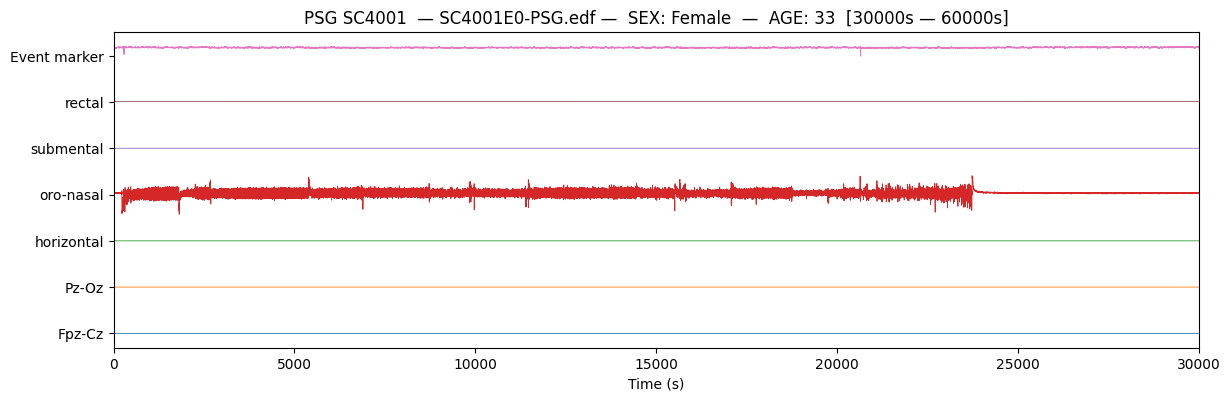

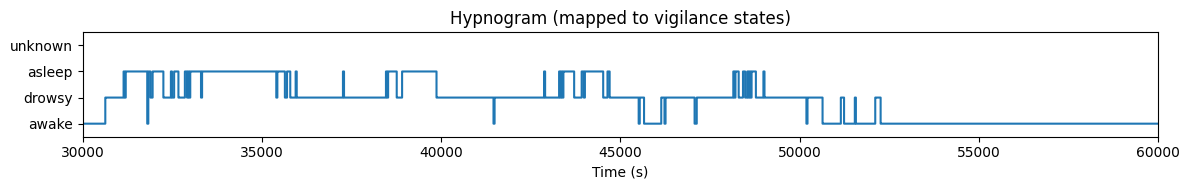

In [16]:
# choose a few patient rows (e.g., first 3)
to_plot = patients.iloc[[0]]   # or use .sample(3) for random

for idx, row in to_plot.iterrows():
    # interactive:
    visualize_psg_segment(row, start=30000.0, duration=30000.0, channels=None, interactive=False)
    # OR save static PNG:
    # out = visualize_psg_segment(row, start=0, duration=120.0, channels=None,
    #                             interactive=False, save_png=f"/kaggle/working/{row['patient_id']}_psg.png")


# Why do we only see movement variations from oro-nasal only?
### *because the oro-nasal channel is the one measuring airflow/mouth-nose movement, so it naturally shows large continuous movement related to breathing — while the other channels were plotted with the same scaling so small EEG/EOG activity looks flat* 

# Why a global fixed scale hides small channels

## Different sensors produce very different absolute amplitudes and units. Typical orders of magnitude (approximate): 
* ###  EEG (Fpz–Cz, Pz–Oz): ~10–100 µV (microvolts).

* ###  EOG: ~100–1000 µV (blinks, eye movements larger than cortical EEG).

* ###  EMG (submental): can be hundreds of µV up to mV during bursts.

* ###  Oro-nasal airflow channels: often recorded as large-voltage signals or arbitrary units with much larger peak values (depending on sensor and amplifier scaling).

* ###  Rectal temperature: a small range around ~36°C (plotted on same axis only if converted).

#### If you choose a single y-limit set by the largest amplitude channel (e.g., oro-nasal), anything ~10–100× smaller (EEG) will look like a flat line on that same axis.
#### Long-duration overviews compound the problem: micro-events (theta bursts, blinks) are brief and get visually lost when you compress thousands of seconds onto a single horizontal axis*

# 10. Visualize each signal appart for the Patient 4312 (Functions Modifications )

In [17]:
def visualize_psg_segment1(patient_row, start=0.0, duration=120.0,
                          channels=None, interactive=True, save_png=None,
                          scale='auto'):
    """
    Visualize a PSG segment for one patient row (from patients DataFrame).
    - patient_row: a pd.Series with keys 'patient_id' and 'psg_path' (and hypnogram_path)
    - start, duration: seconds (float)
    - channels: list of channel names to show (None = all)
    - interactive: if True -> mne RawBrowser interactive (raw.plot). If False -> static PNG using matplotlib
    - save_png: if provided (path) saves the static plot (overrides interactive=False)
    - scale: 'auto' or numeric for y-scaling in raw.plot
    """
    pid = patient_row['patient_id']
    psg_path = patient_row['psg_path']
    hyp_path = patient_row.get('hypnogram_path', None)
    sex = patient_row['sex']
    age= patient_row['age']
    sex ="Female " if sex=="F" else "Male "

    if not psg_path or not os.path.exists(psg_path):
        raise FileNotFoundError(f"PSG file not found for {pid}: {psg_path}")

    # load raw (preload small segment into memory)
    raw = mne.io.read_raw_edf(psg_path, preload=True, infer_types=True, verbose=False)

    # attach hypnogram annotations if available
    if hyp_path and os.path.exists(hyp_path):
        ann = mne.read_annotations(hyp_path)
        raw.set_annotations(ann)

    # pick channels if provided
    if channels is not None:
        present = [ch for ch in channels if ch in raw.ch_names]
        if len(present) == 0:
            raise ValueError("None of requested channels present in raw.ch_names")
        raw.pick_channels(present)

    # crop to requested time window
    tmax = start + duration
    raw_crop = raw.copy().crop(tmin=start, tmax=tmax).load_data()

    if interactive and (save_png is None):
        # Open MNE interactive browser (use block=True in script or notebooks)
        raw_crop.plot(n_channels=min(12, len(raw_crop.ch_names)), duration=duration,
                      start=0.0, show=True, block=True, scalings=scale)
        # This opens the MNE RawBrowser; close it to continue execution.
        return None

    # STATIC PLOT: plot each channel in separate subplots
    data, times = raw_crop.get_data(return_times=True)
    n_ch = data.shape[0]
    
    # Create figure with subplots - one for each channel + one for hypnogram
    fig, axes = plt.subplots(n_ch + 1, 1, figsize=(14, 2 + 1.5 * (n_ch + 1)))
    
    # If there's only one channel, axes might not be an array, so make it consistent
    if n_ch == 0:
        raise ValueError("No channels to plot")
    elif n_ch == 1:
        axes = [axes] if n_ch == 1 else axes
    
    # Plot each channel in its own subplot
    for i in range(n_ch):
        ax = axes[i]
        channel_name = raw_crop.ch_names[i]
        ax.plot(times, data[i], lw=1.0, color='blue')
        ax.set_ylabel(f'{channel_name}\n(μV)', rotation=0, ha='right', va='center')
        ax.set_xlim(times[0], times[-1])
        ax.grid(True, alpha=0.3)
        
        # Remove x-axis labels for all but the last plot
        if i < n_ch - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Time (s)")
    
    # Plot hypnogram in the last subplot
    try:
        if hyp_path and os.path.exists(hyp_path):
            plot_hypnogram_from_raw(raw, ax=axes[-1], tmin=start, tmax=tmax)
        else:
            axes[-1].text(0.5, 0.5, "No hypnogram available", 
                         ha='center', va='center', transform=axes[-1].transAxes)
            axes[-1].set_xlabel("Time (s)")
    except Exception as e:
        print(f"Error plotting hypnogram: {e}")
        axes[-1].text(0.5, 0.5, "Error plotting hypnogram", 
                     ha='center', va='center', transform=axes[-1].transAxes)
        axes[-1].set_xlabel("Time (s)")

    # Set main title
    fig.suptitle(f"PSG {pid}  — {os.path.basename(psg_path)} —  SEX: {sex} —  AGE: {age}  [{start:.0f}s — {tmax:.0f}s]", 
                 y=0.98)
    
    plt.tight_layout()

    if save_png:
        outp = Path(save_png)
        outp.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outp, dpi=150, bbox_inches='tight')
        print(f"Saved PSG snapshot to: {outp.resolve()}")
        plt.close(fig)
        return outp.resolve()

    plt.show()
    return None

/tmp/ipykernel_13/2441683785.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


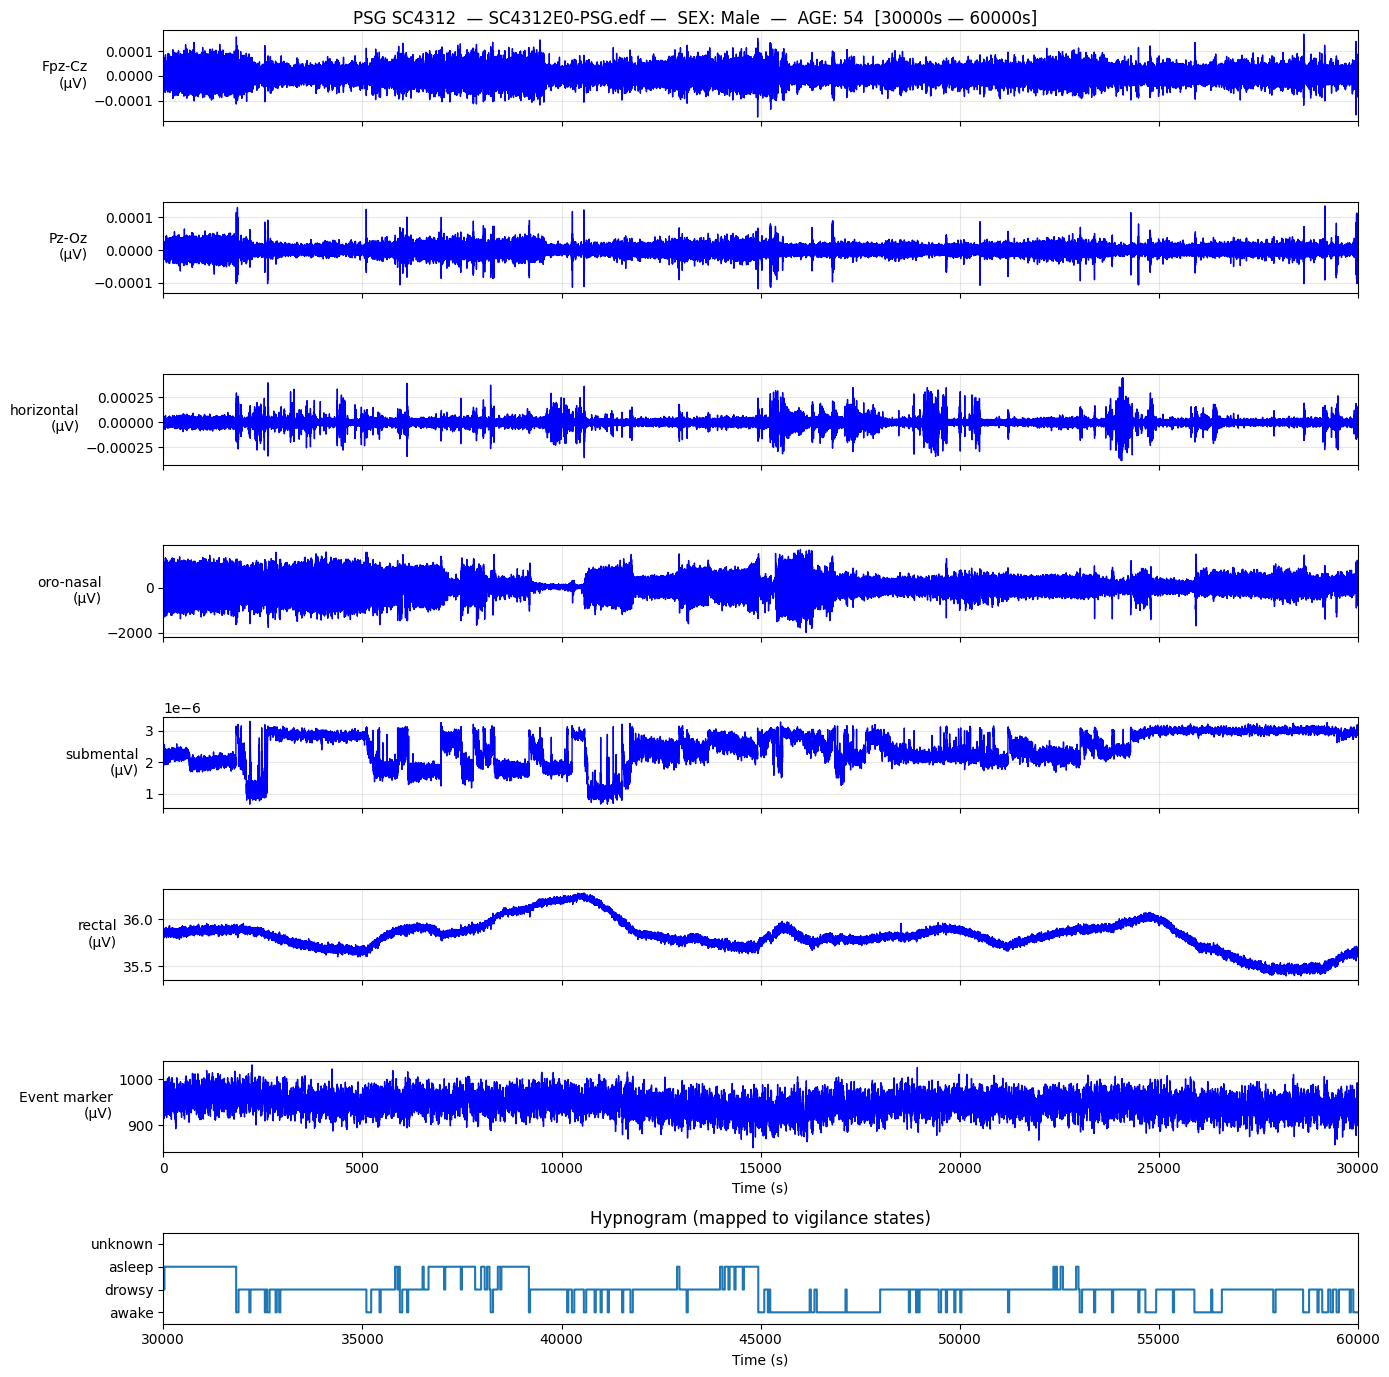

In [18]:
# choose a few patient rows (e.g., first 3)
to_plot = patients.iloc[[62]]   # or use .sample(3) for random

for idx, row in to_plot.iterrows():
    # interactive:
    visualize_psg_segment1(row, start=30000.0, duration=30000.0, channels=None, interactive=False)
    # OR save static PNG:
    # out = visualize_psg_segment(row, start=0, duration=120.0, channels=None,
    #                             interactive=False, save_png=f"/kaggle/working/{row['patient_id']}_psg.png")

# Signals, Meanings and Vigilance Relevance

## Fpz–Cz (Frontal EEG)

- **What it is**: EEG measured between the forehead (Fpz) and midline vertex (Cz)
- **What to look for**:
  - Awake = low-amplitude, faster activity (beta >13 Hz)
  - Relaxed eyes-closed = prominent alpha (8–13 Hz)
  - Drowsiness/sleep-onset = rise in theta (4–7 Hz) and then delta (<4 Hz)
  - Short theta bursts (1–15 s) = microsleeps
- **Why it matters for driving**: Frontal EEG changes are an early, sensitive marker of waning attention. An increase in theta/delta or appearance of microsleeps means the driver may briefly lose situational awareness → big crash risk.

## Pz–Oz (Parietal/Occipital EEG)

- **What it is**: EEG over parietal/occipital areas (visual processing region)
- **What to look for**:
  - Strong alpha when eyes closed/relaxed
  - Alpha suppression when eyes open/attending
  - Transition to theta/delta indicates sleep onset
- **Why it matters for driving**: Changes here show reduced visual information processing (eyes may be open but brain not processing). Loss of occipital alpha suppression or increase of slow waves means degraded visual vigilance.

## Horizontal EOG (Horizontal Electro-oculogram)

- **What it is**: Eye movement signal (left↔right)
- **What to look for**:
  - Frequent fast saccades and normal blink pattern when alert
  - During drowsiness: slow rolling eye movements (SEM), longer blink duration, more frequent blink closures, reduced saccade velocity
- **Why it matters for driving**: Eyelid/eye behavior is the most direct, real-time indicator of visual vigilance. Long blinks/slow rolls precede microsleeps and correlate strongly with lane departures.

## Oro-nasal (Airflow / Breathing)

- **What it is**: Airflow from mouth+nose — measures breathing and gross respiratory events
- **What to look for**:
  - Regular rhythmic airflow when normal
  - Pauses, reduced amplitude or large variability indicate apneas/hypopneas or mouth breathing
  - Sleep-disordered breathing causes sleep fragmentation and daytime sleepiness
- **Why it matters for driving**: Chronic or acute breathing disturbances reduce sleep quality and oxygenation → increased daytime sleepiness and risk of sudden sleep episodes while driving.

## Submental (Chin) EMG

- **What it is**: Electromyogram under the chin — muscle tone of jaw/neck
- **What to look for**:
  - High tone when awake
  - Decreased tone with sleep onset and especially in REM sleep (very low)
  - EMG also shows brief muscle twitches and transient increases with arousal
- **Why it matters for driving**: Falling muscle tone (head nodding, slack jaw) is a direct motor sign of sleepiness and impending microsleep. Loss of tone + head nod is a classic prelude to dangerous lapses.

## Rectal (Core Body Temperature)

- **What it is**: Core temperature measured rectally (°C)
- **What to look for**: Slow circadian changes (lower at night/early morning)
- **Why it matters for driving**: Circadian low points (lower core temp) coincide with natural reductions in alertness (nighttime/early-morning drowsiness). Temperature helps explain why you feel sleepier at certain times even without prior sleep debt.

## Event Marker

- **What it is**: Manual or system markers that annotate notable events (button presses, stimuli, alarms, logged incidents)
- **What to look for**: Align markers with changes in EEG/EOG/EMG to see if e.g., a steering correction followed a microsleep
- **Why it matters for driving**: Essential for correlating external events (lane departure, braking) with physiological lapses — useful for diagnosing cause/effect.

## Hypnogram (Vigilance/Stage Timeline)

- **What it is**: Summary plot mapping wake / drowsy / sleep stages over time
- **What to look for**: Long or frequent transitions to drowsy/asleep states, especially during expected wake periods
- **Why it matters for driving**: Gives the overall picture of how often and when vigilance dropped — the higher-level metric used to evaluate driving risk over a trip.

---

## Putting the Signals Together — Why Multimodal Sensing is Important

- **EEG + EOG + EMG** is the clinical gold standard to detect sleep onset and microsleeps (brain slowing + slow eye movements + muscle tone loss)
- **Airflow + respiratory channels** identify sleep-disordered breathing that increases baseline daytime sleepiness
- **Temperature + circadian context** help predict times of naturally reduced vigilance
- **Combined**, these signals allow robust detection of both gradual vigilance decline (rising theta, more slow eye movements) and abrupt events (short microsleeps)

---

## Practical Signs to Watch for in a Car  
*(What These Signals Correspond To)*

- **Longer blinks, slow eye rolls, staring** → EOG changes (imminent danger)
- **Head nodding, slack jaw, decreased facial muscle tone** → submental EMG drop (very high risk)
- **Brief EEG theta bursts / microsleeps** → short unresponsiveness (can be fatal at highway speed)
- **Frequent respiratory arousals or apneas** → chronic daytime sleepiness → higher baseline crash risk
- **Circadian trough (low rectal temp)** → avoid driving if coupled with sleep debt (late night / early morning)

all_patients_csv = "/kaggle/working/df_all_sleep_data.csv"

# Remove CSV if already exists
if os.path.exists(all_patients_csv):
    os.remove(all_patients_csv)

# Define start and end indices (0-based)
start_idx = 143  # start patient (inclusive)
end_idx = 153    # end patient (exclusive)

chunk_ids = common_ids[start_idx:end_idx]
print(f"Processing patients {start_idx} to {end_idx-1}...")

for i, pid in enumerate(chunk_ids, start_idx):
    print(f"\n[{i+1}/{len(common_ids)}] Processing patient: {pid}")
    
    psg_path = psg_dict[pid]
    hyp_path = hyp_dict[pid]

    # Extract metadata
    age, sex = extract_metadata(hyp_path)
    print(f"  Metadata -> Age: {age}, Sex: {sex}")

    # Load PSG
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
    raw.filter(0.3, 35, verbose=False)
    
    # Normalize
    data, times = raw.get_data(return_times=True)
    data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)

    # Convert PSG to DataFrame
    df_psg = pd.DataFrame(data.T, columns=raw.ch_names)
    df_psg["time_sec"] = times
    df_psg["patient_id"] = pid
    df_psg["age"] = age
    df_psg["sex"] = sex

    # Extract sleep stages
    df_stages = extract_sleep_stages(hyp_path)
    df_stages["patient_id"] = pid
    df_stages["age"] = age
    df_stages["sex"] = sex

    # Merge PSG and sleep stages
    df_merged = pd.merge_asof(df_psg.sort_values("time_sec"),
                              df_stages.sort_values("time_sec"),
                              on="time_sec",
                              direction="backward")

    # Save merged DataFrame
    if not os.path.exists(all_patients_csv):
        df_merged.to_csv(all_patients_csv, index=False)
    else:
        df_merged.to_csv(all_patients_csv, index=False, mode='a', header=False)

    # Free memory
    del df_psg, df_stages, df_merged, data, times, raw
    gc.collect()

print("Selected range processed and saved.")